# Imports

In [1]:
import numpy as np
import cupy as cp
from numba import cuda, vectorize
from numpy import format_float_scientific as fs
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import math

from lbmFlowAroundCylinder import Timer, TimersManager
from lbmFlowAroundCylinder import inivel, obstacle_fun

## Timers definition

In [2]:
timers = TimersManager()
timers.add("main")
timers.add("equilibrium")
timers.add("collision")
timers.add("streaming")
timers.add("macroscopic")
timers.add("rightwall")
timers.add("leftwall")
timers.add("fin_inflow")
timers.add("bounceback")
timers.add("move_gpu->cpu")
timers.add("move_cpu->gpu")

## Flow definitions

In [3]:
maxIter = 2000    # Total number of time iterations.
Re = 150.0          # Reynolds number.
nx, ny = 420, 180   # Numer of lattice nodes.
ly = ny-1           # Height of the domain in lattice units.
cx, cy, r = nx//4, ny//2, ny//9 # Coordinates of the cylinder.
uLB     = 0.04                  # Velocity in lattice units.
nulb    = uLB*r/Re;             # Viscoscity in lattice units.
omega = 1 / (3*nulb+0.5);    # Relaxation parameter.
save_figures = True
profile = True

## Lattice constants

In [4]:
v = cuda.to_device(np.array([ [ 1,  1], [ 1,  0], [ 1, -1], [ 0,  1], [ 0,  0],
               [ 0, -1], [-1,  1], [-1,  0], [-1, -1] ], dtype=np.int32)) # 9 vecteurs : 9 directions de déplacement
v_np = np.empty(shape=v.shape, dtype=v.dtype)
v.copy_to_host(v_np)

t = cuda.to_device(np.array([ 1/36, 1/9, 1/36, 1/9, 4/9, 1/9, 1/36, 1/9, 1/36], 
                            dtype=np.float32))
t_np = np.empty(shape=t.shape, dtype=t.dtype)
t.copy_to_host(t_np)

col1 = np.array([0, 1, 2])
col2 = np.array([3, 4, 5])
col3 = np.array([6, 7, 8])

# Code main functions

## Border Outflow : RightWall

In [5]:
rig_threadsperblock = 8
rig_blockspergrid_y = math.ceil(ny / rig_threadsperblock)
rig_blockspergrid = (rig_blockspergrid_y)


@cuda.jit
def rightwall_cuda(fin):
    y = cuda.grid(1)
    if y < fin.shape[2]:
        fin[6, nx-1, y] = fin[6, nx-2, y]
        fin[7, nx-1, y] = fin[7, nx-2, y]
        fin[8, nx-1, y] = fin[8, nx-2, y]

### Macroscopic

In [6]:
@cuda.jit
def sum_kernel_axis0(A, out):
    """ Performs the sum on axis 0
    """
    y, z = cuda.grid(2)

    if y < A.shape[1] and z < A.shape[2]:
        tmp = 0
        for i in range(A.shape[0]):
            tmp += A[i, y, z]
        out[y, z] = tmp

def macroscopic(fin): 
    """Compute macroscopic variables (density, velocity)

    fluid density is 0th moment of distribution functions 
    fluid velocity components are 1st order moments of dist. functions
    """
    rho = np.sum(fin, axis=0)
    u = np.zeros((2, nx, ny))
    for i in range(9):
        u[0,:,:] += v[i,0] * fin[i,:,:]
        u[1,:,:] += v[i,1] * fin[i,:,:]
    u /= rho
    return rho, u
        
        
mac_threadsperblock = (16, 16)
mac_blockspergrid_x = math.ceil(nx / mac_threadsperblock[0])
mac_blockspergrid_y = math.ceil(ny / mac_threadsperblock[1])
mac_blockspergrid = (mac_blockspergrid_x, mac_blockspergrid_y)


@cuda.jit
def macroscopic_cuda(fin, v, rho_out, u_out):
    x, y = cuda.grid(2)
    if x < rho_out.shape[0] and y < rho_out.shape[1]:
        rho_tmp = 0
        ux_tmp = 0
        uy_tmp = 0
        for ipop in range(9):
            rho_tmp += fin[ipop, x, y]
            ux_tmp += v[ipop, 0] * fin[ipop, x, y]
            uy_tmp += v[ipop, 1] * fin[ipop, x, y]
        rho_out[x, y] = rho_tmp
        u_out[0, x, y] = ux_tmp / rho_tmp
        u_out[1, x, y] = uy_tmp / rho_tmp

## LeftWall

In [7]:
lef_threadsperblock = 8
lef_blockspergrid_y = math.ceil(ny / lef_threadsperblock)
lef_blockspergrid = (lef_blockspergrid_y)
# Appelé comme ça 
#leftwall_cuda[lef_blockspergrid, lef_threadsperblock](fin_device, vel_device, u_device, rho_device)


@cuda.jit
def leftwall_cuda(fin, vel, u_out, rho_out):
    y = cuda.grid(1)
    if y < fin.shape[2]:
        ux = vel[0, 0, y]
        u_out[0, 0, y] = ux
        u_out[1, 0, y] = vel[1, 0, y]
        rho_out[0, y] = (1 / (1 - ux)) * (fin[3, 0, y] + fin[4, 0, y] + fin[5, 0, y] + \
                                        2 * (fin[6, 0, y] + fin[7, 0, y] + fin[8, 0, y]))

## Equilibrium

In [8]:
def equilibrium(rho, u):
    """Equilibrium distribution function.
    """
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    feq = np.zeros((9,nx,ny))
    for i in range(9):
        cu = 3 * (v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i] * (1 + cu + 0.5*cu**2 - usqr) 
        # feq[i,:,:] : dimension 1 la direction de déplacement de la particule
        #               dimension 2 et 3 : x et y la position
    return feq

equ_threadsperblock = (16, 16)
equ_blockspergrid_x = math.ceil(nx / equ_threadsperblock[0])
equ_blockspergrid_y = math.ceil(ny / equ_threadsperblock[1])
equ_blockspergrid   = (equ_blockspergrid_x, equ_blockspergrid_y)

@cuda.jit
def equilibrium_cuda(rho, u, v, t, feq_out):
    x, y = cuda.grid(2)
    if x < rho.shape[0] and y < rho.shape[1]:
        ux = u[0, x, y]
        uy = u[1, x, y]
        usqr = 1.5 * (ux * ux + uy * uy) 
        for ipop in range(9):
            cu = 3 * (v[ipop, 0] * ux + v[ipop, 1] * uy)
            feq_out[ipop, x, y] = rho[x, y] * t[ipop] * (1 + cu + 0.5 * cu * cu - usqr)

## Fin_Inflow

In [9]:
inf_threadsperblock = 8
inf_blockspergrid_y = math.ceil(ny / inf_threadsperblock)
inf_blockspergrid = (inf_blockspergrid_y)

@cuda.jit
def fin_inflow_cuda(feq, fin_out):
    y = cuda.grid(1)
    if y < fin_out.shape[2]:
        fin_out[0, 0, y] = feq[0, 0, y] + fin_out[8, 0, y] - feq[8, 0, y]
        fin_out[1, 0, y] = feq[1, 0, y] + fin_out[7, 0, y] - feq[7, 0, y]
        fin_out[2, 0, y] = feq[2, 0, y] + fin_out[6, 0, y] - feq[6, 0, y]

## Collision

In [10]:
col_threadsperblock = (16, 16)
col_blockspergrid_x = math.ceil(nx / col_threadsperblock[0])
col_blockspergrid_y = math.ceil(ny / col_threadsperblock[1])
col_blockspergrid   = (col_blockspergrid_x, col_blockspergrid_y)

@cuda.jit
def collision_cuda(fin, feq, f_out):
    x, y = cuda.grid(2)
    if x < fin.shape[1] and y < fin.shape[2]:
        for ipop in range(9):
            f_out[ipop, x, y] = fin[ipop, x, y] - omega * (fin[ipop, x, y] - feq[ipop, x, y])

## BounceBack

In [11]:
bou_threadsperblock = (16, 16)
bou_blockspergrid_x = math.ceil(nx / bou_threadsperblock[0])
bou_blockspergrid_y = math.ceil(ny / bou_threadsperblock[1])
bou_blockspergrid   = (bou_blockspergrid_x, bou_blockspergrid_y)


@cuda.jit
def bounceback_cuda(fin, obstacle, f_out):
    x, y = cuda.grid(2)
    if x < obstacle.shape[0] and y < obstacle.shape[1]:
        if obstacle[x, y] == 1:
            for i in range(9):
                f_out[i, x, y] = fin[8 - i, x, y]

## Streaming Step

In [12]:
str_threadsperblock = (16, 16)
str_blockspergrid_x = math.ceil(nx / str_threadsperblock[0])
str_blockspergrid_y = math.ceil(ny / str_threadsperblock[1])
str_blockspergrid   = (str_blockspergrid_x, str_blockspergrid_y)

@cuda.jit
def streaming_cuda(fout, v, fin_out):
    x, y = cuda.grid(2)
    if x < fout.shape[1] and y < fout.shape[2]:
        for ipop in range(9):
            i_out = x - v[ipop, 0]
            if i_out < 0:
                i_out += nx
            if i_out > nx - 1:
                i_out -= nx
            j_out = y - v[ipop, 1]
            if j_out < 0:
                j_out += ny
            if j_out > ny - 1:
                j_out -= ny
            fin_out[ipop, x, y] = fout[ipop, i_out, j_out]

### Main loop

In [13]:
def main():
    # create obstacle mask array from element-wise function
    obstacle = np.fromfunction(obstacle_fun, (nx,ny))
    obstacle_device = cuda.to_device(obstacle)
    
    # initial velocity field vx,vy from element-wise function
    # vel is also used for inflow border condition
    vel = np.fromfunction(inivel, (2,nx,ny)) 
    vel_device = cuda.to_device(vel)
    
    # Initialization of the populations at equilibrium 
    # with the given velocity.
    fin = equilibrium(1, vel)
    fin_device = cuda.to_device(fin)
    
    rho = np.zeros(shape=(fin.shape[1], fin.shape[2]))
    rho_device = cuda.to_device(rho)
    
    u = np.zeros((2, nx, ny), dtype=np.float32)
    u_device = cuda.to_device(u)
    
    feq = np.zeros_like(fin)
    feq_device = cuda.to_device(feq)
    
    fout = np.zeros_like(fin)
    fout_device = cuda.to_device(fout)
    

    ###### Main time loop ########
    for time in range(maxIter):
        # Right wall: outflow condition.
        # we only need here to specify distrib. function for velocities
        # that enter the domain (other that go out, are set by the streaming step)
        
        timers.get("rightwall").start()
        #fin[col3,nx-1,:] = fin[col3,nx-2,:] 
        rightwall_cuda[rig_blockspergrid, rig_threadsperblock](fin_device)
        timers.get("rightwall").end()

        
        timers.get("move_cpu->gpu").start()
        rho_device = cuda.to_device(rho)
        u_device = cuda.to_device(u)
        timers.get("move_cpu->gpu").end()
        # Compute macroscopic variables, density and velocity.
        timers.get("macroscopic").start()
        macroscopic_cuda[mac_blockspergrid, mac_threadsperblock](fin_device, v, rho_device, u_device) # Timer in func
        #rho, u = macroscopic(fin)
        timers.get("macroscopic").end()
        
        """timers.get("move_gpu->cpu").start() # A remettre pour exécution sur CPU
        rho_device.copy_to_host(rho)           # A remettre pour exécution sur CPU
        u_device.copy_to_host(u)               # A remettre pour exécution sur CPU
        fin_device.copy_to_host(fin)           # A remettre pour exécution sur CPU
        timers.get("move_gpu->cpu").end()"""   # A remettre pour exécution sur CPU
        
        # Left wall: inflow condition.
        timers.get("leftwall").start()
        ########################## NE FONCTIONNE PAS
        #u[:,0,:] = vel[:,0,:]                                             # A remettre pour exécution sur CPU
        #rho[0,:] = 1/(1-u[0,0,:]) * ( np.sum(fin[col2,0,:], axis=0) +     # A remettre pour exécution sur CPU
        #                                2*np.sum(fin[col3,0,:], axis=0) ) # A remettre pour exécution sur CPU
        leftwall_cuda[lef_blockspergrid, lef_threadsperblock](fin_device, vel_device, u_device, rho_device)
        timers.get("leftwall").end()
        
        timers.get("move_cpu->gpu").start()
        """rho_device = cuda.to_device(rho)    # A remettre pour exécution sur CPU
        u_device = cuda.to_device(u)"""        # A remettre pour exécution sur CPU
        feq_device = cuda.to_device(feq)       
        timers.get("move_cpu->gpu").end()   
        
        # Compute equilibrium.
        timers.get("equilibrium").start()
        equilibrium_cuda[equ_blockspergrid, equ_threadsperblock](rho_device, u_device, v, t, feq_device) # Timer in func
        #feq = equilibrium(rho, u)
        timers.get("equilibrium").end()
    
        timers.get("move_gpu->cpu").start()
        rho_device.copy_to_host(rho)
        u_device.copy_to_host(u)
        feq_device.copy_to_host(feq)
        timers.get("move_gpu->cpu").end()
    
        timers.get("fin_inflow").start()
        #fin_inflow_cuda[inf_blockspergrid, inf_threadsperblock](feq_device, fin_device)
        fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]
        timers.get("fin_inflow").end()

        
        timers.get("move_cpu->gpu").start()
        fin_device = cuda.to_device(fin)
        fout_device = cuda.to_device(fout)
        feq_device = cuda.to_device(feq)
        timers.get("move_cpu->gpu").end()
        
        # Collision step.
        timers.get("collision").start()
        #fout = fin - omega * (fin - feq) # Noyau de calcul 1
        collision_cuda[col_blockspergrid, col_threadsperblock](fin_device, feq_device, fout_device)
        timers.get("collision").end()

    
        
        # Bounce-back condition for obstacle.
        # in python language, we "slice" fout by obstacle
        timers.get("bounceback").start()
        bounceback_cuda[bou_blockspergrid, bou_threadsperblock](fin_device, obstacle_device, fout_device)
        #for i in range(9):
        #    fout[i, obstacle] = fin[8-i, obstacle]
        timers.get("bounceback").end()


        # Streaming step.
        timers.get("streaming").start()
        #for i in range(9):
        #    fin[i,:,:] = np.roll(np.roll(fout[i,:,:], v_np[i,0], axis=0),
        #                         v_np[i,1], axis=1 ) # Noyau de calcul 2
        streaming_cuda[str_blockspergrid, str_threadsperblock](fout_device, v, fin_device)
        timers.get("streaming").end()

        
        timers.get("move_gpu->cpu").start()
        fout_device.copy_to_host(fout)
        feq_device.copy_to_host(feq)
        timers.get("move_gpu->cpu").end()
        
        if ((time%100==0) and save_figures):
            plt.clf()
            u_device.copy_to_host(u)
            plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)
            plt.show()
            #plt.savefig("figures/vel.{0:04d}.png".format(time//100))


/home/Arthur.VIENS/miniconda3/envs/numba2021/lib/python3.9/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (23) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/Arthur.VIENS/miniconda3/envs/numba2021/lib/python3.9/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (23) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


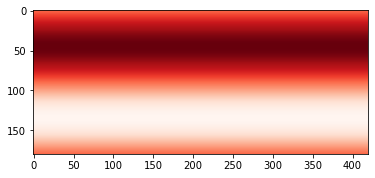

/home/Arthur.VIENS/miniconda3/envs/numba2021/lib/python3.9/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (23) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


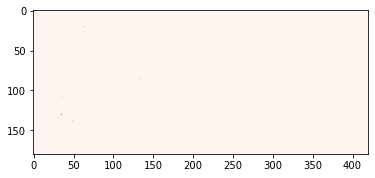

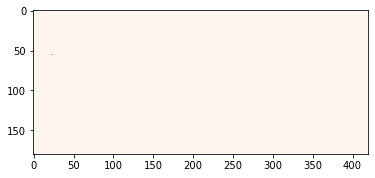

Exception ignored in: <finalize object at 0x7f4ee46f8400; dead>
Traceback (most recent call last):
  File "/home/Arthur.VIENS/miniconda3/envs/numba2021/lib/python3.9/weakref.py", line 591, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/home/Arthur.VIENS/miniconda3/envs/numba2021/lib/python3.9/site-packages/numba/cuda/cudadrv/driver.py", line 1820, in deref
    mem.free()
  File "/home/Arthur.VIENS/miniconda3/envs/numba2021/lib/python3.9/site-packages/numba/cuda/cudadrv/driver.py", line 1633, in free
    self._finalizer()
  File "/home/Arthur.VIENS/miniconda3/envs/numba2021/lib/python3.9/weakref.py", line 591, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/home/Arthur.VIENS/miniconda3/envs/numba2021/lib/python3.9/site-packages/numba/cuda/cudadrv/driver.py", line 1301, in core
    deallocations.add_item(driver.cuMemFree, handle, size)
  File "/home/Arthur.VIENS/miniconda3/envs/numba2021/lib/python3.9/site-packages/numba/cuda/cud

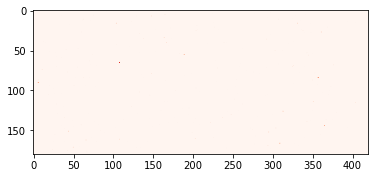

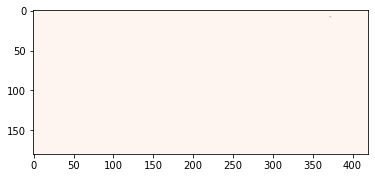

/tmp/ipykernel_1510936/3698152111.py:86: RuntimeWarning: invalid value encountered in subtract
  fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]


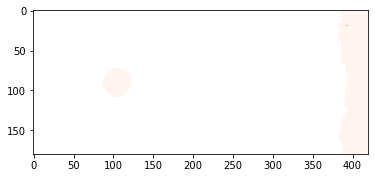

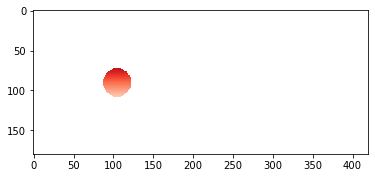

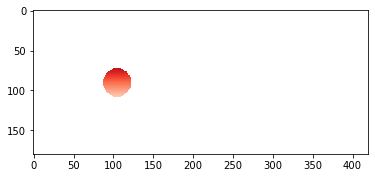

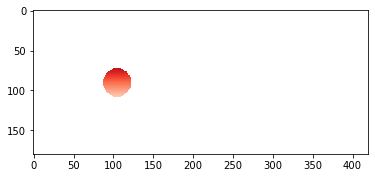

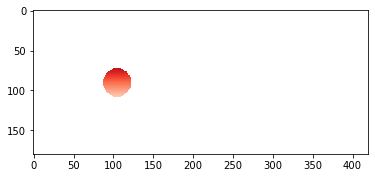

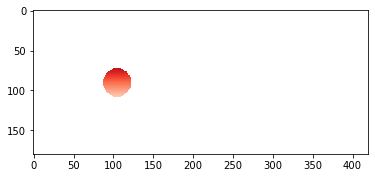

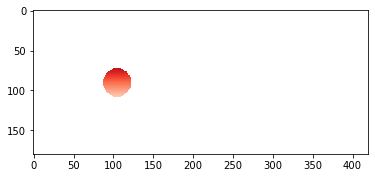

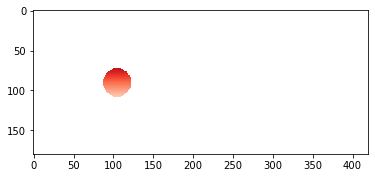

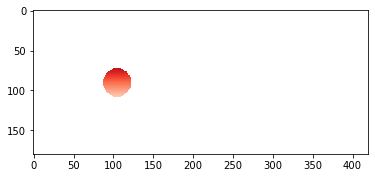

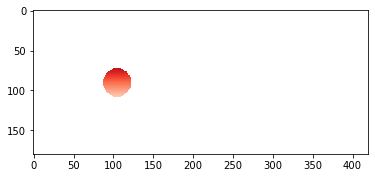

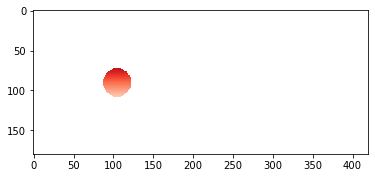

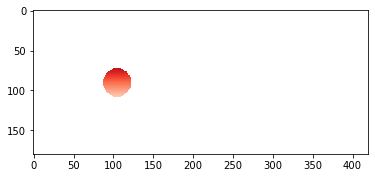

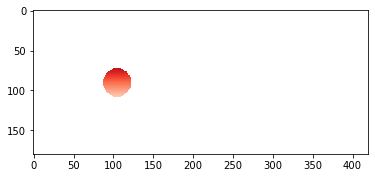

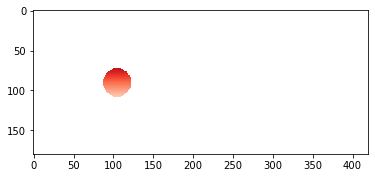

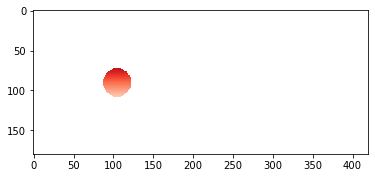

In [14]:
timers.get("main").start()
main()
timers.get("main").end()

# Warnings ignorés pour l'instant, à régler à la fin

In [15]:
total = np.sum(timers.get("main").getMeasures())
print(f"Total time : {total:4.2f}s")
timers.printInfo()

Total time : 17.05s
--> Timer 'main         ' : N =    1 | Mean 1.705e+01 +- 0.e+00     | 100.0% of total time.
--> Timer 'equilibrium  ' : N = 2000 | Mean 1.967e-04 +- 3.524e-03  |  2.31% of total time.
--> Timer 'collision    ' : N = 2000 | Mean 1.526e-04 +- 1.294e-03  |  1.79% of total time.
--> Timer 'streaming    ' : N = 2000 | Mean 1.248e-04 +- 1.794e-03  |  1.46% of total time.
--> Timer 'macroscopic  ' : N = 2000 | Mean 1.532e-04 +- 1.955e-03  |   1.8% of total time.
--> Timer 'rightwall    ' : N = 2000 | Mean 2.14e-04  +- 5.669e-03  |  2.51% of total time.
--> Timer 'leftwall     ' : N = 2000 | Mean 1.457e-04 +- 1.691e-03  |  1.71% of total time.
--> Timer 'fin_inflow   ' : N = 2000 | Mean 4.883e-05 +- 3.260e-06  |  0.57% of total time.
--> Timer 'bounceback   ' : N = 2000 | Mean 1.673e-04 +- 1.218e-03  |  1.96% of total time.
--> Timer 'move_gpu->cpu' : N = 4000 | Mean 1.104e-03 +- 1.859e-04  | 25.91% of total time.
--> Timer 'move_cpu->gpu' : N = 6000 | Mean 1.415e-03 +- 9.3

## Tests